Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are - closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. -"Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

In [2]:
X_train = pd.read_csv("data/train.csv", parse_dates=[2], low_memory=False)
X_test = pd.read_csv("data/test.csv", parse_dates=[3], low_memory=False)
store = pd.read_csv("data/store.csv")

In [3]:
print(X_train["Date"].min(), X_train["Date"].max())
X_train.sort_values(["Date"], inplace=True, kind="mergesort")
X_train.reset_index(drop=True, inplace=True)

2013-01-01 00:00:00 2015-07-31 00:00:00


In [4]:
X_test["Open"] = X_test["Open"].fillna(1)

In [5]:
# TODO: how do handle missing values regarding competitor store
store.fillna(0, inplace=True)

In [6]:
X_train = pd.merge(X_train, store, on="Store", how="left")
X_test = pd.merge(X_test, store, on="Store", how="left")

In [7]:
for df in [X_train, X_test]:
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    assert np.all(df["DayOfWeek"] - 1 == df['Date'].dt.dayofweek)
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['weekofyear'] = df['Date'].dt.weekofyear
    df.drop("Date", axis=1, inplace=True)

In [8]:
for df in [X_train, X_test]:
    df["CompetitionOpen"] = ((df["year"] - df["CompetitionOpenSinceYear"]) * 12
                             + (df["month"] - df["CompetitionOpenSinceMonth"]))
    df["CompetitionOpen"] = df["CompetitionOpen"].apply(lambda x: x if x > 0 else 0)
    df["PromoOpen"] = ((df["year"] - df["Promo2SinceYear"]) * 12
                       + (df["weekofyear"] - df["Promo2SinceWeek"]) / 4)
    df["PromoOpen"] = df["PromoOpen"].apply(lambda x: x if x > 0 else 0)

In [9]:
month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
def check(row):
    if isinstance(row['PromoInterval'], str) and month2str[row['month']] in row['PromoInterval']:
        if (row['year'] > row['Promo2SinceYear'] or
            (row['year'] == row['Promo2SinceYear'] and row['weekofyear'] > row['Promo2SinceWeek'])):
            return 1
    return 0
for df in [X_train, X_test]:
    df['IsPromoMonth'] = df.apply(lambda row: check(row), axis=1) 
    #df.drop("PromoInterval", axis=1, inplace=True)

In [10]:
groups = X_train[["Store", "Open"]].groupby("Store").mean()
groups.rename(columns={"Open":"shopavgopen"}, inplace=True)
X_train = pd.merge(X_train, groups, how="left", on="Store")
X_test = pd.merge(X_test, groups, how="left", on="Store")

In [11]:
groups = X_train[["Store", "Sales", "Customers"]].groupby("Store").sum()
groups["shopavgsalespercustomer"] = groups["Sales"] / groups["Customers"]
del groups["Sales"], groups["Customers"]
X_train = pd.merge(X_train, groups, how="left", on="Store")
X_test = pd.merge(X_test, groups, how="left", on="Store")

In [12]:
groups = X_train[["Store", "SchoolHoliday"]].groupby("Store").mean()
groups.rename(columns={"SchoolHoliday":"shopavgschoolholiday"}, inplace=True)
X_train = pd.merge(X_train, groups, how="left", on="Store")
X_test = pd.merge(X_test, groups, how="left", on="Store")

In [13]:
groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
groups2 = X_train[X_train["StateHoliday"] != "0"][["Store", "Sales"]].groupby("Store").sum()
groups = pd.merge(groups1, groups2, on="Store")
groups["shopsalesholiday"] = groups["Sales_y"] / groups["Sales_x"]
del groups["Sales_x"], groups["Sales_y"]
X_train = pd.merge(X_train, groups, how="left", on="Store")
X_test = pd.merge(X_test, groups, how="left", on="Store")

In [14]:
groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
groups2 = X_train[X_train["IsPromoMonth"] == 1][["Store", "Sales"]].groupby("Store").sum()
groups = pd.merge(groups1, groups2, on="Store")
groups["shopsalespromo"] = groups["Sales_y"] / groups["Sales_x"]
del groups["Sales_x"], groups["Sales_y"]
X_train = pd.merge(X_train, groups, how="left", on="Store")
X_test = pd.merge(X_test, groups, how="left", on="Store")

In [15]:
groups1 = X_train[["Store", "Sales"]].groupby("Store").sum()
groups2 = X_train[X_train["DayOfWeek"] == 6][["Store", "Sales"]].groupby("Store").sum()
groups = pd.merge(groups1, groups2, on="Store")
groups["shopsalessaturday"] = groups["Sales_y"] / groups["Sales_x"]
del groups["Sales_x"], groups["Sales_y"]
X_train = pd.merge(X_train, groups, how="left", on="Store")
X_test = pd.merge(X_test, groups, how="left", on="Store")

In [16]:
assert np.all(X_train[X_train["Open"] == 0]["Sales"] == 0)
# X_train = X_train[X_train["Open"] == 1]
X_train = X_train[X_train["Sales"] != 0]
del X_train["Open"]
test_close_ind = np.where(X_test["Open"] == 0)[0]
del X_test["Open"]

In [17]:
for col in ["StateHoliday", "StoreType", "Assortment", "DayOfWeek", "month", "PromoInterval"]:
    for val in X_train[col].unique():
        new_col_name = col + "_" + str(val)
        X_train[new_col_name] = (X_train[col] == val).astype(int)
        X_test[new_col_name] = (X_test[col] == val).astype(int)
del X_train["PromoInterval"], X_test["PromoInterval"]

In [18]:
for col in ["StateHoliday", "StoreType", "Assortment"]:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

In [19]:
y_train = np.array(X_train["Sales"])
X_train.drop("Sales", axis=1, inplace=True)
X_train.drop("Customers", axis=1, inplace=True)
test_ID = X_test["Id"]
X_test.drop("Id", axis=1, inplace=True)

In [20]:
y_train = np.log1p(y_train)

In [21]:
def rmspe(y_true, y_pred):
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    err = np.sqrt(np.mean((1 - y_pred / y_true) ** 2))
    return err

def rmspe_xgb(y_pred, y_true):
    y_true = y_true.get_label()
    err = rmspe(np.expm1(y_true), np.expm1(y_pred))
    return "rmspe", err

In [22]:
valid_mask = (X_train["year"] == 2015) & (X_train["dayofyear"] >= 171)  # last 6 weeks
X_train_1, y_train_1 = X_train[~valid_mask], y_train[~valid_mask]
X_train_2, y_train_2 = X_train[valid_mask], y_train[valid_mask]
reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                       random_state=0, tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
        eval_metric=rmspe_xgb, early_stopping_rounds=100, verbose=100)
best_iteration = reg.best_iteration

[0]	validation_0-rmse:8.02077	validation_1-rmse:8.02757	validation_0-rmspe:0.999809	validation_1-rmspe:0.999811
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.430094	validation_1-rmse:0.434688	validation_0-rmspe:0.350472	validation_1-rmspe:0.337031
[200]	validation_0-rmse:0.142173	validation_1-rmse:0.159	validation_0-rmspe:0.190785	validation_1-rmspe:0.164135
[300]	validation_0-rmse:0.114661	validation_1-rmse:0.137713	validation_0-rmspe:0.158668	validation_1-rmspe:0.147126
[400]	validation_0-rmse:0.100485	validation_1-rmse:0.127604	validation_0-rmspe:0.140553	validation_1-rmspe:0.136942
[500]	validation_0-rmse:0.092873	validation_1-rmse:0.122087	validation_0-rmspe:0.131798	validation_1-rmspe:0.131095
[600]	validation_0-rmse:0.088042	validation_1-rmse:0.118945	validation_0-rmspe:0.122863	validation_1-rmspe:0.127547
[700]	validation_0-rmse:0.084626	

In [23]:
pred = np.expm1(reg.predict(X_test))
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred},
                          columns=["Id", "Sales"])
# 0.11690 0.11939
submission.to_csv("submit/v1_1.csv", index=False)

RMSPE: 0.1218


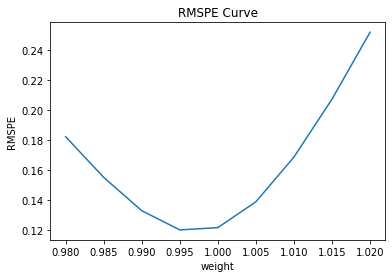

Best weight is 0.995, RMSPE is 0.1202


In [24]:
# correction, see https://www.kaggle.com/c/rossmann-store-sales/discussion/17601#latest-100894
y_pred = reg.predict(X_train_2)
error = rmspe(np.expm1(y_train_2), np.expm1(y_pred))
print("RMSPE: {:.4f}".format(error))
weights = np.arange(0.98, 1.02, 0.005)
errors = []
for w in weights:
    error = rmspe(np.expm1(y_train_2), np.expm1(y_pred * w))
    errors.append(error)
plt.figure()
plt.plot(weights, errors)
plt.xlabel('weight')
plt.ylabel('RMSPE')
plt.title('RMSPE Curve')
plt.show()
print("Best weight is {}, RMSPE is {:.4f}".format(weights[np.argmin(errors)], np.min(errors)))

In [25]:
pred = np.expm1(reg.predict(X_test) * 0.995)
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred},
                          columns=["Id", "Sales"])
# 0.11392 0.11196
submission.to_csv("submit/v1_2.csv", index=False)

In [26]:
X_train, y_train = X_train[y_train != 0], y_train[y_train != 0]
reg = xgb.XGBRegressor(n_estimators=best_iteration, objective="reg:squarederror", max_depth=10,
                       learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                       random_state=0, tree_method="gpu_hist", gpu_id=0)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train)],
        eval_metric=rmspe_xgb, early_stopping_rounds=100, verbose=100)

[0]	validation_0-rmse:8.02108	validation_0-rmspe:0.999809
Multiple eval metrics have been passed: 'validation_0-rmspe' will be used for early stopping.

Will train until validation_0-rmspe hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.429655	validation_0-rmspe:0.348924
[200]	validation_0-rmse:0.143011	validation_0-rmspe:0.189378
[300]	validation_0-rmse:0.115159	validation_0-rmspe:0.155911
[400]	validation_0-rmse:0.10085	validation_0-rmspe:0.13395
[500]	validation_0-rmse:0.092914	validation_0-rmspe:0.124476
[600]	validation_0-rmse:0.087718	validation_0-rmspe:0.118258
[700]	validation_0-rmse:0.084345	validation_0-rmspe:0.111821
[800]	validation_0-rmse:0.081607	validation_0-rmspe:0.105381
[900]	validation_0-rmse:0.079204	validation_0-rmspe:0.097228
[1000]	validation_0-rmse:0.077259	validation_0-rmspe:0.090241
[1100]	validation_0-rmse:0.075528	validation_0-rmspe:0.086593
[1200]	validation_0-rmse:0.073974	validation_0-rmspe:0.083857
[1300]	validation_0-rmse:0.072573	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=0,
             importance_type='gain', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=None, n_estimators=1461,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.9, tree_method='gpu_hist',
             verbosity=1)

In [27]:
pred = np.expm1(reg.predict(X_test))
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred},
                          columns=["Id", "Sales"])
# 0.11357 0.10751
submission.to_csv("submit/v1_3.csv", index=False)

In [28]:
pred = np.expm1(reg.predict(X_test) * 0.995)
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred},
                          columns=["Id", "Sales"])
# 0.11245 0.10437
submission.to_csv("submit/v1_4.csv", index=False)

In [29]:
pred = np.zeros(X_test.shape[0])
n_models = 5
for i in range(n_models):
    print("=== model " + str(i) + " ===")
    reg = xgb.XGBRegressor(n_estimators=5000, objective="reg:squarederror", max_depth=10,
                           learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                           random_state=i, tree_method="gpu_hist", gpu_id=0)
    reg.fit(X_train_1, y_train_1, eval_set=[(X_train_1, y_train_1), (X_train_2, y_train_2)],
            eval_metric=rmspe_xgb, early_stopping_rounds=100, verbose=100)
    best_iteration = reg.best_iteration
    reg = xgb.XGBRegressor(n_estimators=best_iteration, objective="reg:squarederror", max_depth=10,
                           learning_rate=0.03, colsample_bytree=0.7, subsample=0.9,
                           random_state=i, tree_method="gpu_hist", gpu_id=0)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train)],
            eval_metric=rmspe_xgb, early_stopping_rounds=100, verbose=100)
    pred += np.expm1(reg.predict(X_test) * 0.995)
pred /= n_models
pred[test_close_ind] = 0
submission = pd.DataFrame({"Id": test_ID, "Sales": pred},
                           columns=["Id", "Sales"])
# 0.11180 0.10257
submission.to_csv("submit/v1_5.csv", index=False)

=== model 0 ===
[0]	validation_0-rmse:8.02077	validation_1-rmse:8.02757	validation_0-rmspe:0.999809	validation_1-rmspe:0.999811
Multiple eval metrics have been passed: 'validation_1-rmspe' will be used for early stopping.

Will train until validation_1-rmspe hasn't improved in 100 rounds.
[100]	validation_0-rmse:0.430382	validation_1-rmse:0.433858	validation_0-rmspe:0.350826	validation_1-rmspe:0.336482
[200]	validation_0-rmse:0.143107	validation_1-rmse:0.159251	validation_0-rmspe:0.189848	validation_1-rmspe:0.164263
[300]	validation_0-rmse:0.114097	validation_1-rmse:0.137039	validation_0-rmspe:0.158157	validation_1-rmspe:0.145955
[400]	validation_0-rmse:0.100466	validation_1-rmse:0.127428	validation_0-rmspe:0.135956	validation_1-rmspe:0.136322
[500]	validation_0-rmse:0.092618	validation_1-rmse:0.122038	validation_0-rmspe:0.125547	validation_1-rmspe:0.130442
[600]	validation_0-rmse:0.08772	validation_1-rmse:0.11917	validation_0-rmspe:0.115587	validation_1-rmspe:0.127242
[700]	validation

[200]	validation_0-rmse:0.142169	validation_1-rmse:0.159686	validation_0-rmspe:0.191389	validation_1-rmspe:0.164808
[300]	validation_0-rmse:0.115665	validation_1-rmse:0.138895	validation_0-rmspe:0.163945	validation_1-rmspe:0.148105
[400]	validation_0-rmse:0.101877	validation_1-rmse:0.128401	validation_0-rmspe:0.139309	validation_1-rmspe:0.137335
[500]	validation_0-rmse:0.09332	validation_1-rmse:0.123178	validation_0-rmspe:0.127884	validation_1-rmspe:0.131933
[600]	validation_0-rmse:0.087816	validation_1-rmse:0.120054	validation_0-rmspe:0.117419	validation_1-rmspe:0.128616
[700]	validation_0-rmse:0.084344	validation_1-rmse:0.118307	validation_0-rmspe:0.108716	validation_1-rmspe:0.126619
[800]	validation_0-rmse:0.081524	validation_1-rmse:0.117441	validation_0-rmspe:0.102148	validation_1-rmspe:0.125695
[900]	validation_0-rmse:0.079241	validation_1-rmse:0.116781	validation_0-rmspe:0.096432	validation_1-rmspe:0.124905
[1000]	validation_0-rmse:0.077277	validation_1-rmse:0.11623	validation_0-

[1100]	validation_0-rmse:0.075484	validation_1-rmse:0.114624	validation_0-rmspe:0.089544	validation_1-rmspe:0.122109
[1200]	validation_0-rmse:0.073908	validation_1-rmse:0.11429	validation_0-rmspe:0.085313	validation_1-rmspe:0.121731
[1300]	validation_0-rmse:0.072399	validation_1-rmse:0.114184	validation_0-rmspe:0.081991	validation_1-rmspe:0.121648
[1400]	validation_0-rmse:0.071092	validation_1-rmse:0.1141	validation_0-rmspe:0.078974	validation_1-rmspe:0.121553
[1500]	validation_0-rmse:0.069907	validation_1-rmse:0.114081	validation_0-rmspe:0.077074	validation_1-rmspe:0.121478
[1600]	validation_0-rmse:0.068813	validation_1-rmse:0.114021	validation_0-rmspe:0.074804	validation_1-rmspe:0.121408
[1700]	validation_0-rmse:0.067688	validation_1-rmse:0.113934	validation_0-rmspe:0.072774	validation_1-rmspe:0.121325
[1800]	validation_0-rmse:0.066687	validation_1-rmse:0.113849	validation_0-rmspe:0.071254	validation_1-rmspe:0.121243
[1900]	validation_0-rmse:0.065743	validation_1-rmse:0.113816	valida